In [90]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import math

from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets


## Nozzle Plotter

Input quantities:

- throat radius
- throat curve radius
- expansion half-angle
- ratio of exit area to throat area



In [201]:
class Nozzle:
    def __init__(self,r_t,r_1,alpha,epsilon):
        self.r_t = r_t # radius of throat
        self.r_1 = r_1 # radius of throat curvature
        self.alpha = alpha # expansion half-angle
        self.epsilon = epsilon # throat to exit area ratio
        
        self.recalc() # get derived quantities for initial values
        
    def recalc(self):
        # Establish coordinates for arcs
        self.arcCenter = (0,self.r_t + self.r_1)
        self.arclCenter = (0,-(self.r_t + self.r_1))
        
        # Establish coordinates for wall lines
        #n_x and n_y are coordinates for the entry point
        self.n_x = self.r_1*math.sin(math.radians(self.alpha))
        self.n_y = self.r_t+(self.r_1*(1-math.cos(math.radians(self.alpha))))
        
        #e_x and e_y are coordinates for the exit point
        self.r_e = math.sqrt(self.epsilon)*self.r_t
        self.e_y = self.r_e
        self.e_x = self.n_x + (self.r_e-self.n_y)/math.tan(math.radians(self.alpha))
        
    def newParams(self,r_t,r_1,alpha,epsilon):
        self.r_t = r_t
        self.r_1 = r_1
        self.alpha = alpha # expansion half-angle
        self.epsilon = epsilon # throat to exit area ratio
        
        self.recalc() # get derived quantities for initial values
        self.draw() # draw new figure
        
    def area(self,x): # return area of nozzle at position x
        xmin = -self.r_1  # minimum x
        x_trans = self.n_x # transition x
        x_out = self.e_x # x at exit
        retval = 0
        
        if(x<xmin):
            #print("x below range")
            z=0
        elif(x>=xmin and x<x_trans):
            #x is within inlet circle
            retval = math.pi*((self.r_t+self.r_1)-(math.sqrt((self.r_1**2)-(x**2))))**2
        elif(x>x_trans and x<=x_out):
            # x is in cone area
            m = ((self.e_y-self.n_y)/(self.e_x-self.n_x))
            b = (-m)*(self.n_x)+self.n_y
            
            retval = math.pi*((m*x+b)**2) #d'oh
        else:
            #print("x is above range")
            z=0
        return retval
    
    def xvals(self): # returns a list that evenly divides the x-coordinates into intervals
        
        
    
    def draw(self):
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111)
        
        axes = plt.gca()
        axes.set_xlim([-1,9])
        axes.set_ylim([-3,3])
        
        figh = 2*self.r_1
        figw = 2*self.r_1
        arc = mpatches.Arc(xy=self.arcCenter,width=figw,height=figh,theta1=180, theta2=270+self.alpha)
        arcLow = mpatches.Arc(xy=self.arclCenter,width=figw,height=figh,theta1=90-self.alpha, theta2=180)
        
        ax.add_patch(arc)
        ax.add_patch(arcLow)
        
        ax.plot([self.n_x,self.e_x],[self.n_y,self.e_y])
        ax.plot([self.n_x,self.e_x],[-self.n_y,-self.e_y])
        
        plt.show()

In [221]:
schnozz = Nozzle(0.5,1,15,5)

w_tr = widgets.FloatSlider(min=0.1,
                           max=1, 
                           step=0.05,
                           value=0.5,
                           continuous_update=False,
                          description = 'Throat Radius') # throat radius widget
w_tc = widgets.FloatSlider(min=0.1, 
                           max=1, 
                           step =0.05,
                           value=0.7,
                           continuous_update=False,
                          description = 'Curve Radius') # throat curve radius widget
w_a = widgets.FloatSlider(min=0.1,
                          max=30, 
                          step=0.1,
                           continuous_update=False,
                         description='Wall Angle') # wall angle widget
w_e = widgets.FloatSlider(min=1.1, 
                          max=10, 
                          step=0.1,
                           continuous_update=False,
                         description='Area Ratio') # area ratio widget
ui = widgets.VBox([w_tr,w_tc,w_a,w_e])

out = widgets.interactive_output(schnozz.newParams, {'r_t':w_tr,'r_1':w_tc,'alpha':w_a,'epsilon':w_e})

display(ui,out)

Output()

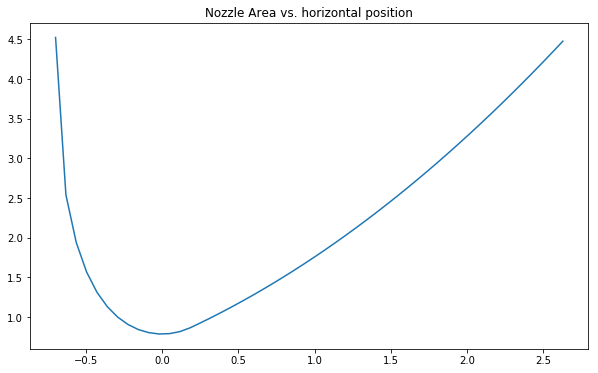

In [238]:
#
# Plotting out area vs. horizontal position
#

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


xrange = np.linspace(-schnozz.r_1,schnozz.e_x,num=50)
#print(xrange)

yrange = []
for x in xrange:
    yrange.append(schnozz.area(x))

ax.plot(xrange,yrange)
plt.title("Nozzle Area vs. horizontal position")
plt.show()




# Derived Quantities

Quantities of interest are massflow, pressure, temperature, density, and velocity.


## Continuity relation
$\dot m = \rho A(x)\bar V$

- massflow is equal to change in mass over time, and is constant

## Constants

In [239]:
A_0 = schnozz.area(0)

# These are for our exhaust gas at the throat of the nozzle.
p_0 = 101325
R_s = 287.058
T_0 = 2253.15

massflow = 2 # this is in kg /s

## Density of Exhaust Gas

$ \rho = \frac{p}{R_{spec}}{T} $

For our conditions

$p = 101325$ Assuming one atmosphere of pressure

$R_{spec} = 287.058 \frac{J}{Kg \cdot K} $  This is for air - update later to exhaust gas composition

$T = 1980^\circ C = 2253.15 K $

In [240]:
rho = lambda x: p_0/(R_s*T_0)

print(rho(0))

0.1566595420040594


## Exhaust Velocity

For small values of velocity V relative to c, velocity can be approximated using the relation for incompressible flow:


$ \bar VA = constant $

Given the area at the throat and the velocity at the throat $A_0$ and $\bar V_0$,

$ \bar V(x) = A(x)\frac{\bar V_0}{A_0} $

Also

$ \dot m = \rho A(x)V(x) $

$ V(x) = \frac{\dot m }{\rho A(x)} $


In [241]:
V = lambda x: massflow/(schnozz.area(x)*rho(x))

[-0.7        -0.63204317 -0.56408633 -0.4961295  -0.42817267 -0.36021583
 -0.292259   -0.22430217 -0.15634533 -0.0883885  -0.02043166  0.04752517
  0.115482    0.18343884  0.25139567  0.3193525   0.38730934  0.45526617
  0.523223    0.59117984  0.65913667  0.7270935   0.79505034  0.86300717
  0.930964    0.99892084  1.06687767  1.13483451  1.20279134  1.27074817
  1.33870501  1.40666184  1.47461867  1.54257551  1.61053234  1.67848917
  1.74644601  1.81440284  1.88235967  1.95031651  2.01827334  2.08623017
  2.15418701  2.22214384  2.29010068  2.35805751  2.42601434  2.49397118
  2.56192801  2.62988484]
2.6298848432842203
[2.8220244901054157, 5.026621362664923, 6.586065340567325, 8.14871474166598, 9.731000174544628, 11.295768763579721, 12.778280818969076, 14.096799320912952, 15.16334552924947, 15.896603139913664, 16.235486727936088, 16.15034971333713, 15.64872405440873, 14.773843889965935, 13.779689307142093, 12.882548005944189, 12.070251509381299, 11.332428945484931, 10.660246927620301

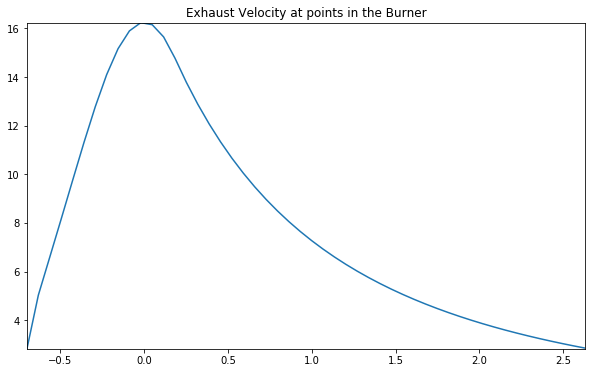

In [243]:
velocity = []

xrange = np.linspace(-schnozz.r_1,schnozz.e_x,num=50)
for x in xrange:
    velocity.append(V(x))
    
print(xrange)
print(max(xrange))
print(velocity)


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


axes = plt.gca()
axes.set_ylim([min(velocity),max(velocity)])
axes.set_xlim([min(xrange),max(xrange)])
    
ax.plot(xrange,velocity)
plt.title("Exhaust Velocity at points in the Burner")
plt.show()

## Temperature of exhaust gases

$Pv = mR_{spec}T$

$T = \frac{Pv}{mR_{spec}} $

Reference material:
http://seitzman.gatech.edu/classes/ae6450/nozzle_geometries.pdf